# cats and dogs prediction using inception resnet v2

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [67]:
train_dir = './project/train'
test_dir = './project/test'


In [68]:
import os

print(os.listdir(train_dir))  # Should show ['cats', 'dogs']
print(os.listdir(test_dir))   # Should show ['cats', 'dogs']


['cats', 'dogs']
['cats', 'dogs']


In [69]:
CFG = dict(
    seed = 77,
    batch_size = 20,
    epochs = 6,
    img_size = (299,299),
    patience = 5
)

In [70]:
CFG

{'seed': 77,
 'batch_size': 20,
 'epochs': 6,
 'img_size': (299, 299),
 'patience': 5}

# data augmentation

In [71]:
train_data_generator = ImageDataGenerator(
    validation_split = 0.15,
    rotation_range = 15,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    preprocessing_function=preprocess_input,# used for scaling
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1)

In [72]:
val_data_generator = ImageDataGenerator(
    validation_split = 0.15,
    preprocessing_function = preprocess_input
)

In [73]:
test_data_generator = ImageDataGenerator(
    validation_split = 0.15,
    preprocessing_function = preprocess_input
)

In [74]:
# connect generators to data in folders
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")

Found 475 images belonging to 2 classes.


In [75]:
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")

Found 83 images belonging to 2 classes.


In [76]:
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])


Found 140 images belonging to 2 classes.


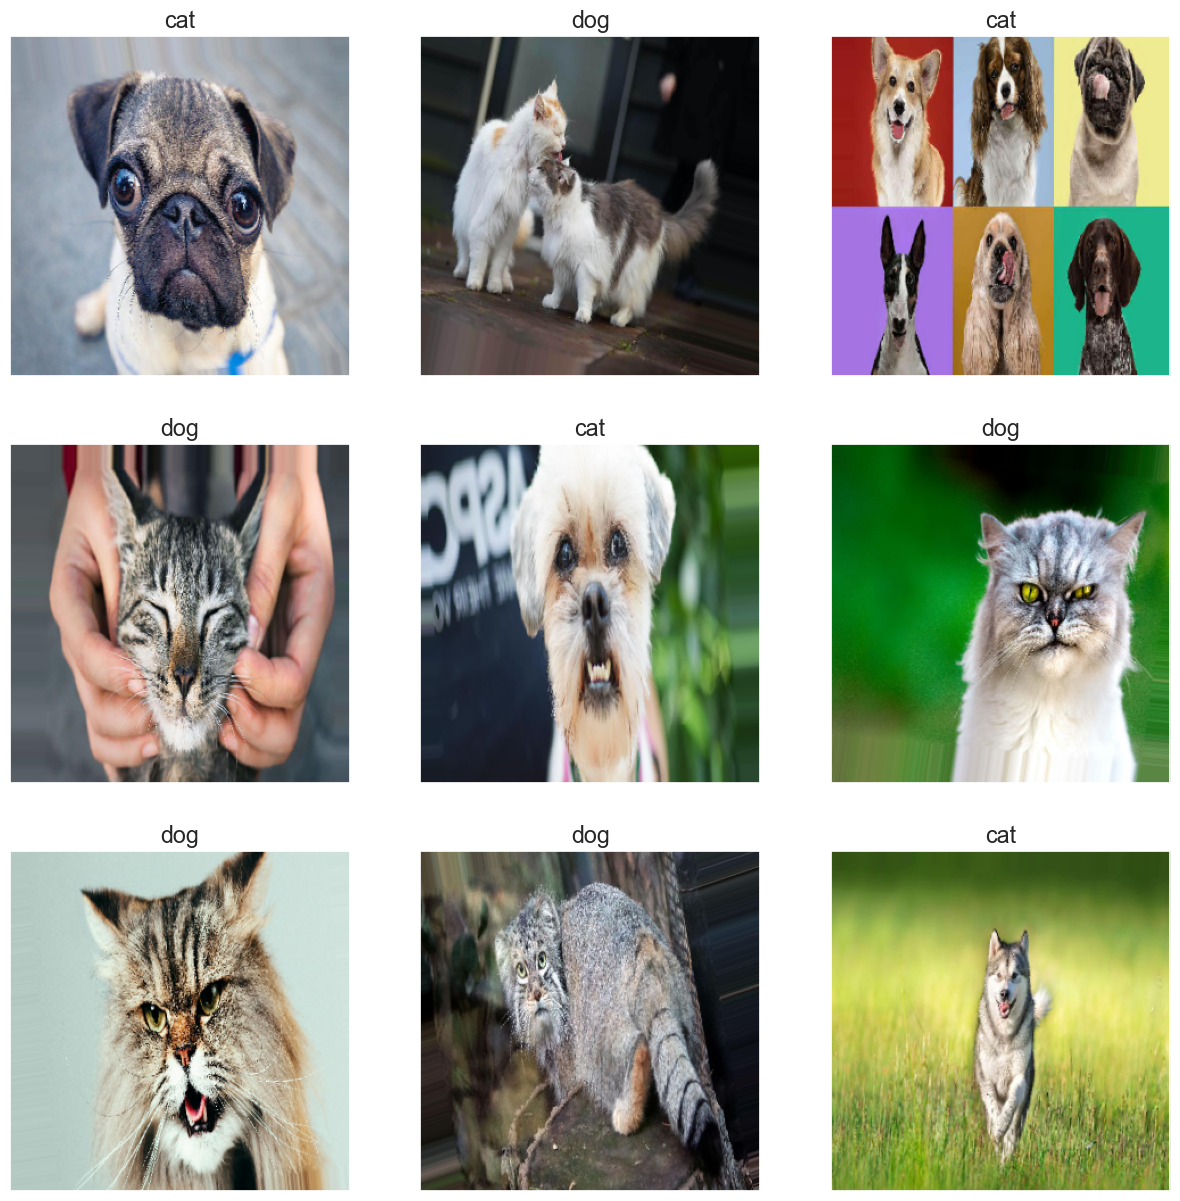

In [77]:
# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(train_generator)
    imgs = (batch[0] + 1) * 127.5
    label = np.argmax(batch[1][0])
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    plt.title('cat' if label==1 else 'dog')
plt.show()

# transfer learning

In [78]:
base_model = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(CFG['img_size'][0],CFG['img_size'][1],3))

In [80]:
x = base_model.output
x = Flatten()(x)
x = Dense(101,activation='relu')(x)
predictions = Dense(2,activation='softmax',kernel_initializer='random_uniform')(x) # output layer


In [81]:
model = Model(inputs=base_model.input,outputs=predictions)

In [82]:
for layer in base_model.layers:
    layer.trainable = False

In [83]:
optimizer = Adam()
model.compile(optimizer,loss = 'categorical_crossentropy',metrics=['accuracy'])

In [84]:
# save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model.h5',monitor='val_loss',save_best_only=True,verbose=1)


In [85]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

In [86]:
# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))
num_classes = len(classes)

Classes:['cats', 'dogs']


In [87]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=CFG['epochs'],
        callbacks=[save_checkpoint,early_stopping],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7803 - loss: 1.0959   
Epoch 1: val_loss improved from None to 0.20627, saving model to model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9033 - loss: 0.5245 - val_accuracy: 0.9500 - val_loss: 0.2063
Epoch 2/6
 1/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9500 - loss: 0.2191

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.20627 to 0.20198, saving model to model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.9500 - loss: 0.2191 - val_accuracy: 0.9500 - val_loss: 0.2020
Epoch 3/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9459 - loss: 0.1449 
Epoch 3: val_loss improved from 0.20198 to 0.07368, saving model to model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9648 - loss: 0.0972 - val_accuracy: 0.9875 - val_loss: 0.0737
Epoch 4/6
 1/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9500 - loss: 0.0507
Epoch 4: val_loss improved from 0.07368 to 0.07105, saving model to model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - accuracy: 0.9500 - loss: 0.0507 - val_accuracy: 0.9875 - val_loss: 0.0710
Epoch 5/6
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9835 - loss: 0.0672     
Epoch 5: val_loss improved from 0.07105 to 0.01488, saving model to model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9890 - loss: 0.0670 - val_accuracy: 0.9875 - val_loss: 0.0149
Epoch 6/6
 1/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 1.0000 - loss: 8.4919e-04
Epoch 6: val_loss improved from 0.01488 to 0.01473, saving model to model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 1.0000 - loss: 8.4919e-04 - val_accuracy: 0.9875 - val_loss: 0.0147


In [88]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.014206637628376484
Val accuracy: 0.9879518151283264


In [89]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08838603645563126
Test accuracy: 0.9857142567634583


7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


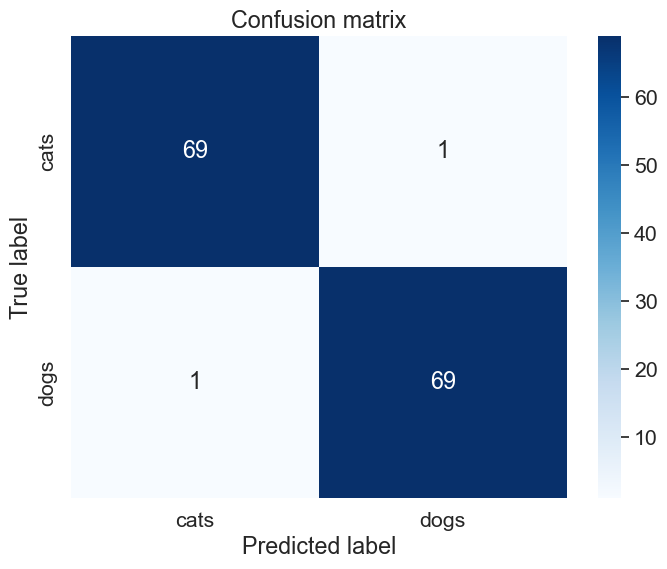

In [90]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from PIL import Image
import numpy as np

# Define the custom layer
class CustomScaleLayer(Layer):
    def __init__(self, scale=1.0, **kwargs):
        super(CustomScaleLayer, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        # If inputs is a list/tuple, combine them first
        if isinstance(inputs, (list, tuple)):
            inputs = tf.add_n(inputs)
        return inputs * self.scale

    def compute_output_shape(self, input_shape):
        # Just return the same shape
        return input_shape[0] if isinstance(input_shape, (list, tuple)) else input_shape

# Load model with custom layer
model = load_model("model.h5", custom_objects={'CustomScaleLayer': CustomScaleLayer})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Predicted class label: 1
Predicted class: Dog


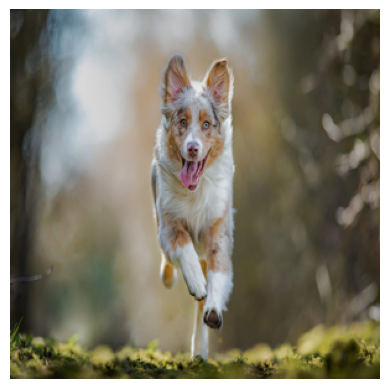

In [27]:
# Class labels
classes = ["cat","Dog"]
from matplotlib import pyplot as plt

# Prediction function
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((299, 299))# 👈 match model input size
    plt.imshow(img)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape (1, 299, 299, 3)
    predicted_class = model.predict(img_array)
    predicted_label = np.argmax(predicted_class, axis=1)[0]
    
    print(f"Predicted class label: {predicted_label}")
    print(f"Predicted class: {classes[predicted_label]}")
    plt.show()
    plt.axis("off")
    plt.grid("off")

# Example
predict_image("dog_0.jpg")